<a href="https://colab.research.google.com/github/prasanna-venkatesh-m/CNN_Cats_vs_Dogs_Classification/blob/main/Data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import PIL
import cv2
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
!curl -L https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip -o cats_and_dogs_filtered.zip
!unzip cats_and_dogs_filtered.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 65.4M  100 65.4M    0     0  12.7M      0  0:00:05  0:00:05 --:--:-- 16.3M
Archive:  cats_and_dogs_filtered.zip
   creating: cats_and_dogs_filtered/
  inflating: cats_and_dogs_filtered/vectorize.py  
   creating: cats_and_dogs_filtered/validation/
   creating: cats_and_dogs_filtered/train/
   creating: cats_and_dogs_filtered/validation/dogs/
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2127.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2126.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2125.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2124.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2123.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2122.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2121.jpg  
  inflating: cats_and_dog

In [3]:
base_dir = '/content/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [4]:
classes = ['Cat', 'Dog']

In [5]:
le = LabelEncoder()

In [47]:
datagen = ImageDataGenerator(
      rotation_range = 50,
      width_shift_range=0.2,
      height_shift_range=0.2,
      brightness_range=None,
      shear_range=0.2,
      zoom_range=0.2,
      channel_shift_range=0.2,
      fill_mode='nearest',
      horizontal_flip=True,
      vertical_flip=True,
  )

In [27]:
def data_augmentation(X,y, no_of_aug=3):
  augmented_X = []
  augmented_y = []
  datagen = ImageDataGenerator(
      rotation_range = 50,
      width_shift_range=0.2,
      height_shift_range=0.2,
      brightness_range=None,
      shear_range=0.2,
      zoom_range=0.2,
      channel_shift_range=0.2,
      fill_mode='nearest',
      horizontal_flip=True,
      vertical_flip=True,
  )

  for i in range(len(X)):
    actual_x = X[i]
    actual_y = y[i]

    img = actual_x.reshape((1,)+actual_x.shape)
    augmented_images = datagen.flow(img, batch_size=no_of_aug)

    for j in range(no_of_aug):
      aug_img = next(augmented_images)[0]
      augmented_X.append(aug_img)
      augmented_y.append(actual_y)

  return np.concatenate([X, np.array(augmented_X)]), np.concatenate([y, np.array(augmented_y)])

In [43]:
def process_data(img_size=(32,32), no_of_aug=3):

  local_x = []
  local_y = []

  for i in range(len(os.listdir(train_dir))):
    dir = os.path.join(train_dir, os.listdir(train_dir)[i])
    for j in range(len(os.listdir(dir))):
      img = cv2.imread(os.path.join(dir, os.listdir(dir)[j]))
      img_resized = cv2.resize(img, img_size)
      local_x.append(img_resized)
      local_y.append(os.listdir(train_dir)[i])

  local_x = np.array(local_x)
  local_x = local_x / 255.0
  local_y = np.array(local_y)
  encoded_y = le.fit_transform(local_y)

  # aug_x, aug_y = data_augmentation(local_x, encoded_y, no_of_aug)

  x_train,x_test, y_train, y_test =train_test_split(local_x, encoded_y, test_size=0.2)
  return x_train, x_test, y_train, y_test

In [44]:
def show_images(x, y, y_pred, n=100):
  plt.figure(figsize=(20,16))
  for i in range(n):
    plt.subplot(10, 20, i+1)
    plt.imshow(x[i])
    if len(y_pred) > 0:
      plt.title(f' {classes[y_pred[i]]} ({classes[y[i]]})')
    else:
      plt.title(f'{classes[y[i]]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [45]:
x_train, x_test, y_train, y_test = process_data((48,48))

In [46]:
print(x_train.shape)
print(x_test.shape)

(1600, 48, 48, 3)
(400, 48, 48, 3)


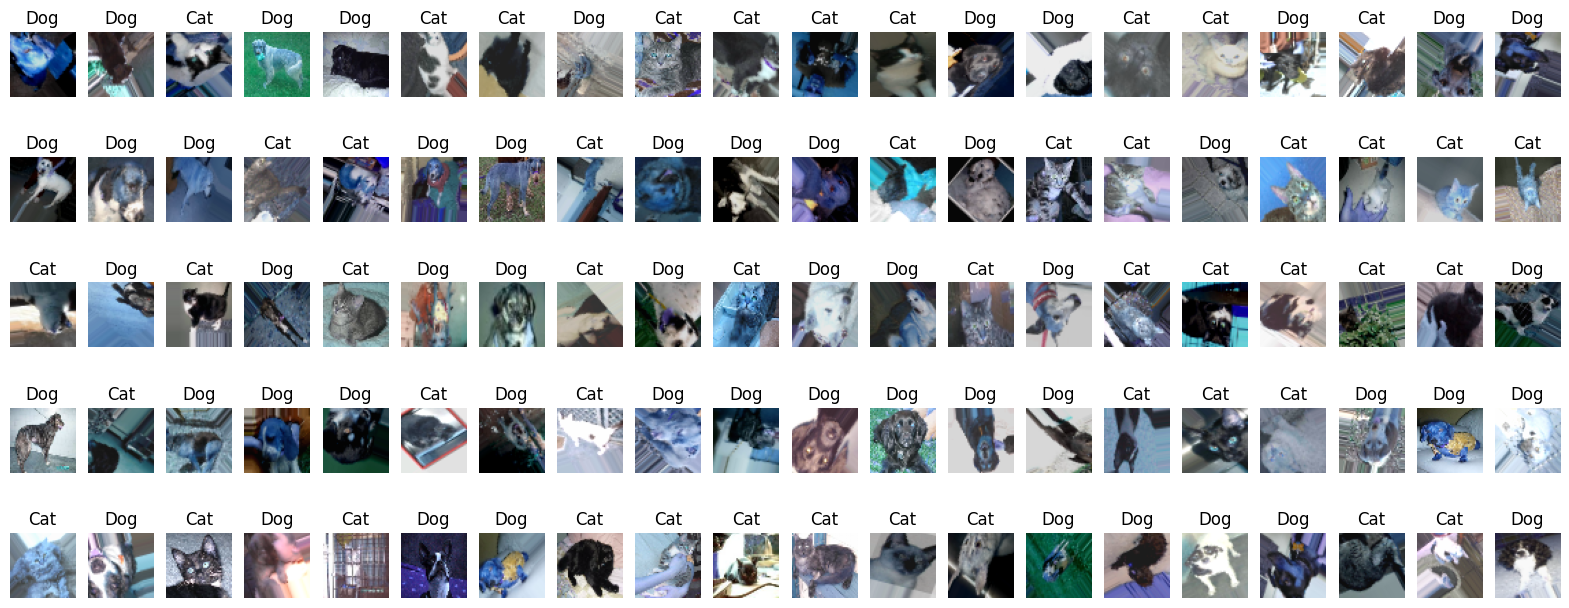

In [35]:
show_images(x_train[6300:], y_train[6300:], [])

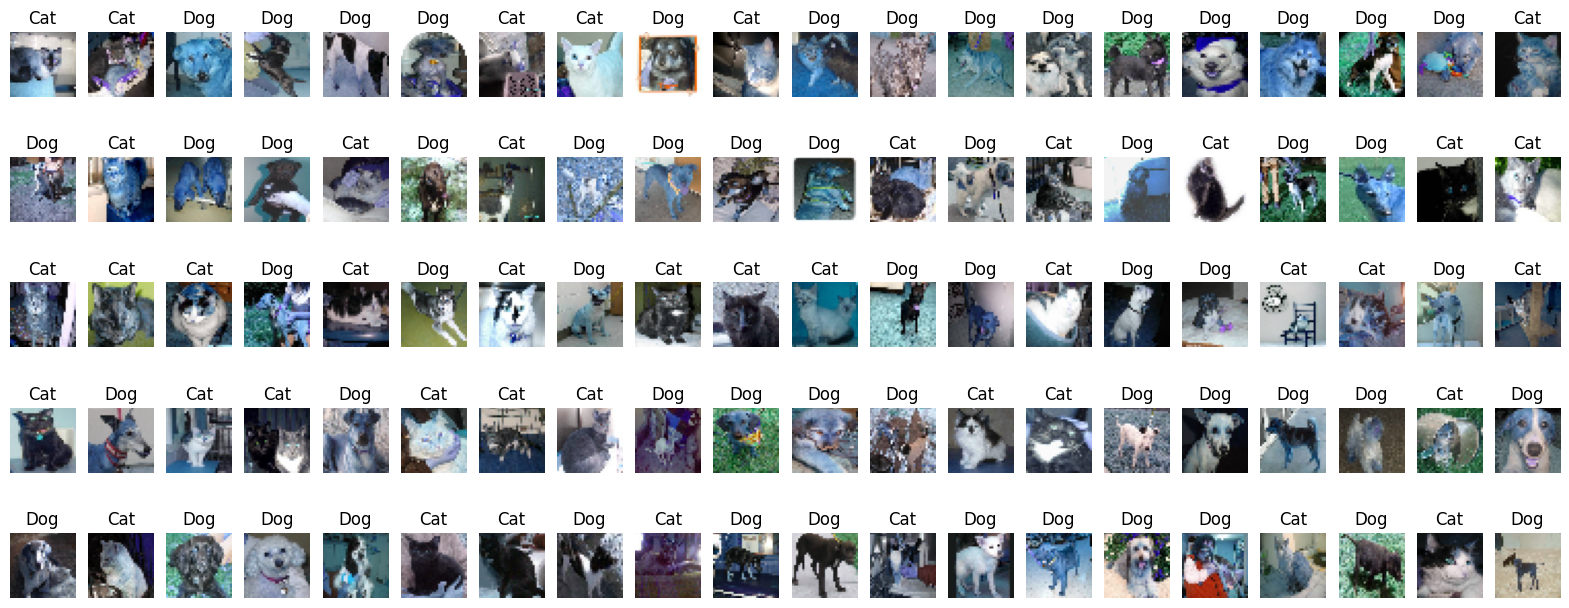

In [ ]:
show_images(x_train,y_train, [] )

In [36]:
def evalute_model(y, y_pred):
  result = np.argmax(y_pred, axis=1)
  print(accuracy_score(y, result))

In [53]:
def train_model(x_train, y_train, x_test, y_test, epochs=20):
  model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3), activation='relu', padding='same', input_shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3])),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2,2)),

    tf.keras.layers.Conv2D(64,(3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2,2)),

    tf.keras.layers.Conv2D(128,(3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.MaxPool2D((2,2)),

    tf.keras.layers.Conv2D(64,(3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Dropout(rate=0.4),
    tf.keras.layers.MaxPool2D((2,2)),

    tf.keras.layers.Conv2D(32,(3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.MaxPool2D((2,2)),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(1024, activation='relu'),
    # tf.keras.layers.Dropout(rate=0.4),
    tf.keras.layers.Dense(512, activation='relu'),
    # tf.keras.layers.Dropout(rate=0.4),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax'),
])
  model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
  train_generator = datagen.flow(x_train, y_train, batch_size=32)
  model.fit(train_generator, epochs=epochs, validation_data=(x_test, y_test))
  # y_pred = model.predict(x_test)
  # return y_pred

In [57]:
y_pred = train_model(x_train, y_train, x_test, y_test, epochs=300)
# evalute_model(y_test, y_pred)

Epoch 1/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 92ms/step - accuracy: 0.5233 - loss: 0.7259 - val_accuracy: 0.5000 - val_loss: 0.6944
Epoch 2/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.6083 - loss: 0.6661 - val_accuracy: 0.5000 - val_loss: 0.7153
Epoch 3/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6088 - loss: 0.6494 - val_accuracy: 0.5000 - val_loss: 0.6937
Epoch 4/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.6094 - loss: 0.6529 - val_accuracy: 0.5075 - val_loss: 0.7073
Epoch 5/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.6358 - loss: 0.6481 - val_accuracy: 0.5000 - val_loss: 0.7734
Epoch 6/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6427 - loss: 0.6396 - val_accuracy: 0.5525 - val_loss: 0.6860
Epoch 7/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6779 - loss: 0.6157 - val_accuracy: 0.5375 - val_loss: 0.7002
Epoch 8/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6784 - loss: 0.6227 - val_accuracy: 0